# Final Report : House Pricing Challenge

> $ Group$ $ 3:  $ 
* $ ARRIAU$ $Emma$
* $ GUIGA $ $ Chloé $
* $ LUSCAN$ $ Pierre$
* $ MOSCHINI$ $ Irina$



**Introduction**: 

This challenge, adapted from the 'Zillow's Home Value Prediction' competition on Kaggle, consists in predicting the selling prices of some US properties. Given a dataset containing descriptions of a thousand homes, we tried to develop a model which accurately fits the available training data while also generalizing to unseen data-points.

This *presentation notebook* gives a concise summary of our findings. It will be structured in the following way : 

**I. Data Preparation**

**II. Model Selection**

**III. Performance Evaluation** 

A *scratch notebook* is also available, where you will find our all code.


In [0]:
from google.colab import drive
from IPython.display import Image
import pandas as pd

In [0]:
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# I. Data Preparation

## I.1. Data cleaning

The first step of our work was to clean the data (which would allow us to both familiarize ourselves and work with on the following steps)
 
- We first checked the coherence of the data sets (I.1.a)
- And treated caterogical features (I.1.a)

### I.1.a. Checking the type, values and shape of the features

* We first checked that the dataset did not contain any duplicate.

* We then checked for each feature that the data type data was correct (we first did not pay attention to the NaN values, we will deal with them later - I.1.b). Example for the MSSubClass feature: 

In [0]:
MSSubClass_type=[20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190]

In [0]:
MSSubClass_test=pd.DataFrame(train['MSSubClass'].isin(MSSubClass_type))

In [0]:
MSSubClass_test[MSSubClass_test['MSSubClass']==False].count()

MSSubClass    0
dtype: int64

> We found the following problems. It was typo problems only (the names of categories were uncorrectly spelled in the .txt file describing the features):

* *MSZoning*:  The category *C* was spelled *C (all)*. Hence, we updated : C (all) for C in the dataframe
* *Neighborhood* : The category was spelled *NAmes* and not *names*.
* *BldgTypePloblems* (3) : 
  * The category is spelled *2fmCon* and not *2FmCon*. 
  * Same for *Duplex* and not *Duplx*. 
  * Same for *Twnhs* and not *TwnhsI*.
* *Exterior2nd* (3) : 
  * *Wd Shng* instead of *WdShing*
  * *CmentBd* instead of *CemntBd*
  * *Brk Cmn* instead of *BrkComm*


* Finally, we  checked that they were not unconsistent data. For example we checked if a house without a pool (a NAN in pool area) displays a NaN value in pool quality. 
  We found two strange rows, regarding the garage related features. We decided to dropped them.

### I.1.b. Dealing with categorical features and NaN values

**Assumption : In this section, we will consider that there are NaN values not because of mistakes, but because there is no such feature.**
(Ie : When Alley = NaN we will assume that it is because there is no alley access.)

It may be an radical assumption, but we took it because of the  work done in the "Checking the type, values and shape of the features" section, where we saw very feew unconstitent data in all our tests.

Dealing with  categorical features and Nan values was the main part of our data cleaning work. 

In order to do so, we first distinguish the features between two main categories : 
- **The numerical features** (**38**): The set of possible values is infinite (Ex : 'LotArea'). 
- **The categorical features** (**43**) : There are a finite number of possible values.
  
  Among the categorical features, we also made the difference bewteen : 
    - **The ordinal features** (**19**): When the different values for a given feature can be clearly ordered. Ie : 'BsmtCond', indeed, we can agree on the fact that *Ex* (Excellent) > *Gd* (Good) > *TA* (Typical) > *Fa* (Fair) > *Po* (Poor)
    - **The nominal features** (**24**): When we cannot order the categories. Ie : 'Alley' (Type of alley access to property) has three values : *Grvl* (Gravel), *Pave* (Paved) and *NA* (No alley access). 


We decided to treat the features differently, regarding the category they belong to. 

#### Numerical features

When it comes to numerical features, there is obviously just to deal with Nan Values.

We saw that most of them are non-null. But we do have : 
- LotFrontage : **259** NaN
- MasVnrArea : **8** NaN
- GarageYrBlt : **81** NaN

The following article, https://towardsdatascience.com/whats-the-best-way-to-handle-nan-values-62d50f738fc, made clear that : 
- There were features where we could reasonably **replace any NaN values with 0** (when 0 is an understandable value). We did so for LotFrontage and MasVnrArea. 
- There were features where it was a bit more complicated, such as GarageYrBlt for instance (Having 0 wouldn't mean anything). According to what the writer says, it is best to impute continuous values using the whole dataset like with methods as **MICE** or **KNN**. This way, the data repartition doesn't change much, with respect to the other variables and output (see the next cell to see how it performs on our data set).

  We will choose to use MICE algorithm, as it is the algorithm that performs the best according to the article. These two other articles mention it, along with its limitations : https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22 (1) , https://conference.scipy.org/proceedings/scipy2018/pdfs/dillon_niederhut.pdf (2).

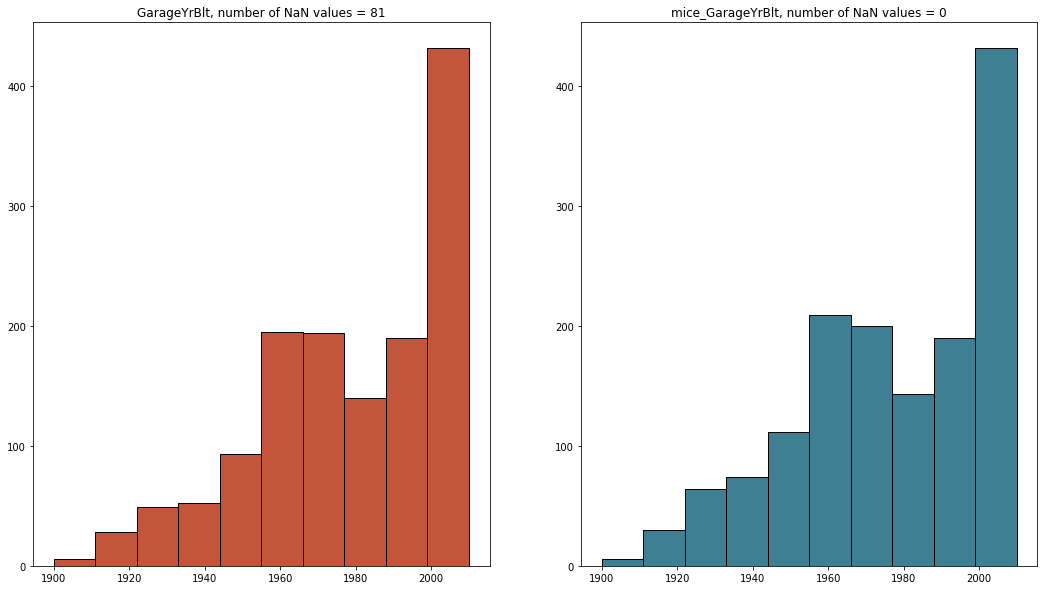

In [0]:
img_mice = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/Mice_algo.png'
Image(filename=img_mice)

Even if Mice Algorithm takes into account the multivariate aspect of our problem, we can see (from a univariate perspective) that it doesn't change much the initial distribution (graph on the left). 

#### Ordinal categorical features

**1. How to deal with the categories?**

As we can order the values of the features, we decided to proceed to a simple transformation. We generated a label encoding scheme for mapping each category to a numeric value, as follow : on a scale from 1 to N (number of categories), the 'better' value will get the higher interger and so on.  
Ie : 
- *Ex* (Excellent) gets 5 
- *Gd* (Good)      gets 4 
- *TA* (Typical)   gets 3 
- *Fa* (Fair)      gets 2 
- *Po* (Poor)      gets 1 

But then, there were two more questions : 

**2. What to do with NA value (when no such feature exists in the house)? And what about NaN values?**

As the assumption says (beginning of this section), all NaN are in fact NA values. We then did the change : NaN values became NA values. We were left with one remaining question :  

**3. What to do with NA value?**

We can not remplace them with a specific value, because we can not compare this NA value with the other one : should it get a higher integer (6 in our exemple) or a lower one (0 in our exemple)?  

Thus, we decided to applied once again the MICE algorithm to the NA values only. 

#### Nominal categorical features

**1. Treatment of NaN values**

**[See assumption]** : We turned NaN values into NA values.


**2. Turning categorical features into numerical values**

We decided to use the **One-hot Encoding Scheme**. 

It consists in transforming 1 feature, taking *n* different values, into *n* binary features. _Example: instead of having one feature "Weather" = {Rain, Sun}, we have 2 features: {Rain} and {Sun}, that owes {Rain = 0} and {Sun = 1} if "Weather" = {Sun}_


**3. Working on the number of features**

By applying the **One-hot Encoding Scheme**, we were expecting (and we had) to have 168 features (versus 24 before applying any transformation). We came with the idea of merging some features (ie 'Condition1' and 'Condition2') by doing an OR operation : 
  - This allowed us to reduce the number of features by 8.
  - Moreover, we would not loose any information.



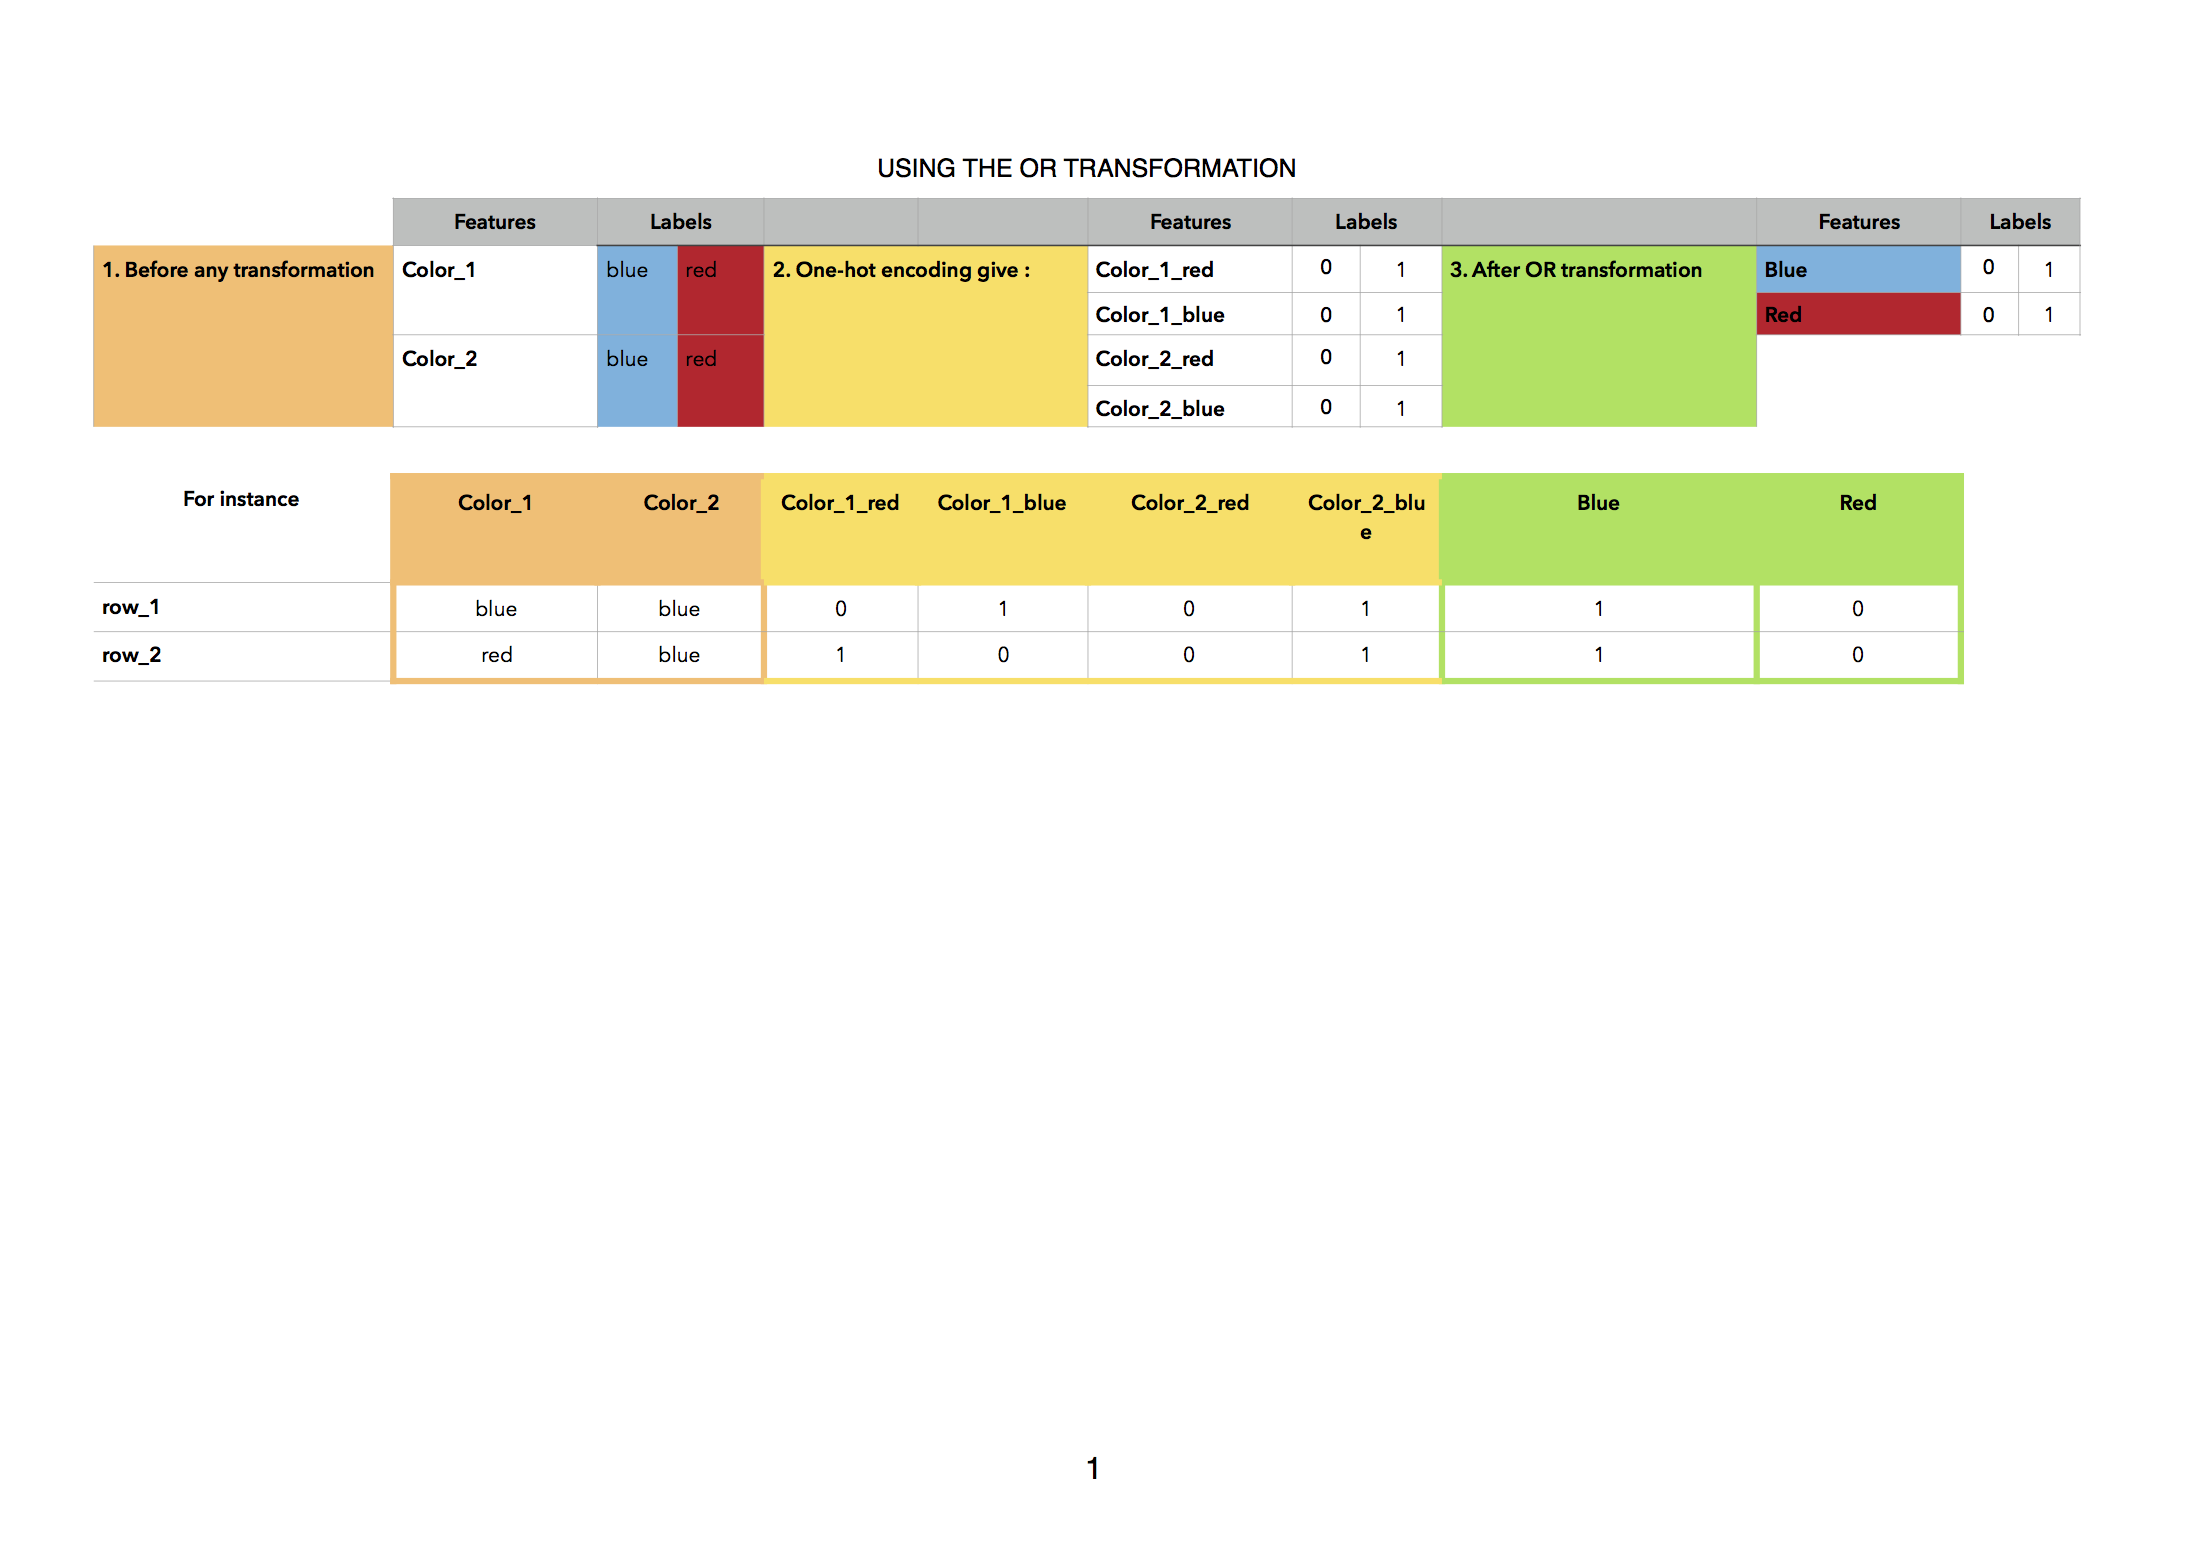

In [0]:
img_OR = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/OR_transf.png'
Image(filename=img_OR)

## I.2. Data visualization

Once the data was cleaned, we first had a look at the output (the SalePrice feature). We noticed that the distribution was closed to a normal distribution (which is really interesting because it's easier to work with data normally distributed). But, it was right-skewed. We then decided to take the log value in order for the distribution to be more symmetrical. 

Moreover, it made sense, since at the end the evaluation method for this challenge is the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price.


You can see below the difference in the distributions. 

Source: https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45


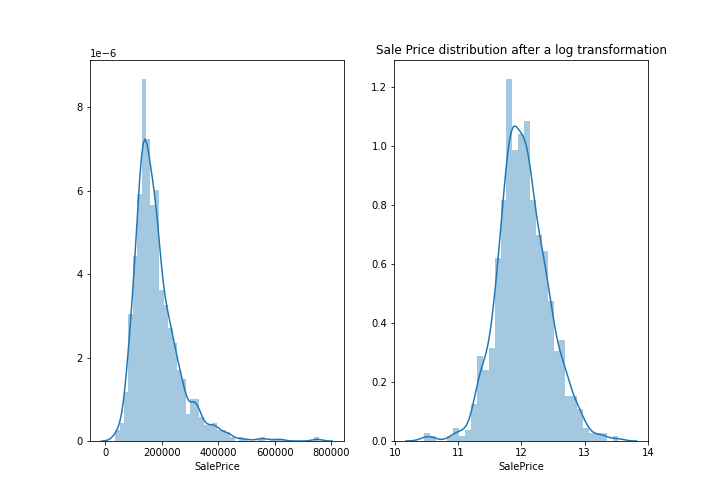

In [0]:
img = '/content/drive/My Drive/House Pricing Prediction Challenge/Pierre/Sale_Price_distribution.png'
Image(filename=img)

Witnessing the effectivness of this transformation, we also checked if it could be interesting to apply a **log transformation** to make other numerical features closer to a normal distribution
To do so, we plotted their distribution and computed the sample skewness.

> We transformed 3 features applying a log transformation: 
  * 1stFlrSF
  * GrLivArea
  * TotRmsAbvGrd

  **Comment** :
  
  These transformations have limits. Indeed, even if having data distribution close to normal distributions, we cannot stop thinking that we changed the impact these three features will have, in comparison with the rest of them. For instance, while 1stFlrSF will be mesured in **log_scale**, 2ndFlrSF will be mesured in **linear** scale. This could be a problem, but we still decided to do it. We indeed figured that the pros compensated for the cons.
 
  

We also made several other plots, which some of them you can find later in the presentation (so that the comments will be relevant in the presentation process). 

## I.3. Removing outliers

**Remark :** 

As we checked that the data was consistent in the first part, we decided not to check outliers on categorical features and to focus only on the **numerical features** which have the **higher correlation value with the output**. Indeed, to remove outliers, we worked only the numerical features which had a correlation coefficient **greater or equal to 0.3**. (see next graph)

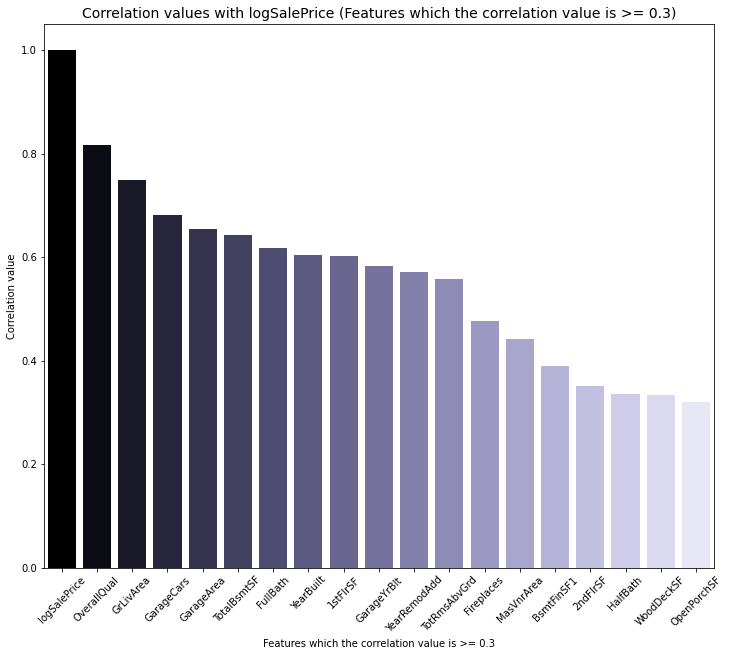

In [0]:
img_corr = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/Corr_features.png'
Image(filename=img_corr)

First, we used the **interquartile range method**:

  Source : https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07
  - *Interquartile range* : IQR = Q3 — Q1 with Q3 the 3rd quartile and Q1 the 1st quartile:
  - *Upper limit* = Q3+3IQR (threshold chosen at +3 and -3 : we tested different threshold and we looked at different websites and 3 seemed to be a good limit)
  - Lower limit = Q1-3IQR
  - Anything below the lower limit and above the upper limit is considered as an outlier.

We could distinguish two types of behaviour :

* When there was to many data to drop, it meant that the feature was unequally distributed (too much 0 values for instance - *MasVnrArea*). So, we decided not to drop any samples for this feature IQR criteria. 
* At the end, we had the following results : 
  * *TotalBsmtSF* ==> 3 Outliers 
  * *GarageArea* ==> 2 Outliers 
  * WoodDeckSF ==> 2 Outliers

**Remark/Conclusion of this technique** : We are aware of the limitations of such method. Indeed, here, the way we deal with outliers doesn't take into account the multivariate aspect of the problem (the fact of having a lot of features). We did it anyway to drop outliers that could disturb our models.

In order to take into account the multivariate aspect of the problem, we completed our study by having a look and applying the **Isolation Forest Algorithm**. With this method, we removed 2 more outliers.
Source : https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

## I.4. Features selection

In total we had **225 features**. When it comes to features selection, we decided that we wanted to make the best **compromises** between : 
- keeping a lot of features, in order to have all the **information** and reaching the higher **performance** for our model.
- dropping features, in order to avoid **overfitting** and obtain a good **interpretability** of our results. 


Moreover, we wanted to have one (or several) data set(s) on wich every model could have a good performance (because some features selection algorithm favor one model over the other ones).



First of all, we dropped the 'Id' feature, as it didn't add any information.


---



The following article (https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2) gave us different methods to do features selection : 
- **Filter based**: We specify some metric and based on that filter features. Ex : 
  - Pearson Correlation
  - Mutual information
- **Wrapper-based**: Wrapper methods consider the selection of a set of features as a search problem. Ex :
  - Recursive Feature Elimination, wich really depends on the model we will use (we decided to use it both with the **Linear Regression** and the **Random Forest Regression*** models).


**Approach** : We decided to test all 3 methods, and counting which features are selected the most? 

*Indeed, these are two models that we will choose on the model selection part.

---
---

We had **two thresholds** to set : 

- Each algorithm asks for a number of features to select (we will call it **num_feats**). We decided to use (**arbitrary choice**) : 
  - num_feats = 50
  - num_feats = 100
  - num_feats = 150
- Once we have all the results, wich features should we take? We decided to keep the features that have been selected by **at least 3** of the 4 algorithms. (**arbitrary choice**)

In [0]:
data = [[50, 47], [100,75], [150,138], [225,'-']]
results = pd.DataFrame(data, columns=['num_feats', 'Number of selected features (after merging) '], index=['data set 1', 'data set 2', 'data set 3', 'data set 4 (without any features selection)'])

results

,num_feats,Number of selected features (after merging)
data set 1,50,47
data set 2,100,75
data set 3,150,138
data set 4 (without any features selection),225,-


**Conclusions** : What we can see is that each algorithm selects more or less the same features. 
We then checked if it was coherent with the what we observed in the data visualisation part : 

- Did we keep all the most correlated features ? YES, we checked that.
- If two features are highly correlated, did we keep only one of them? (see next plot)

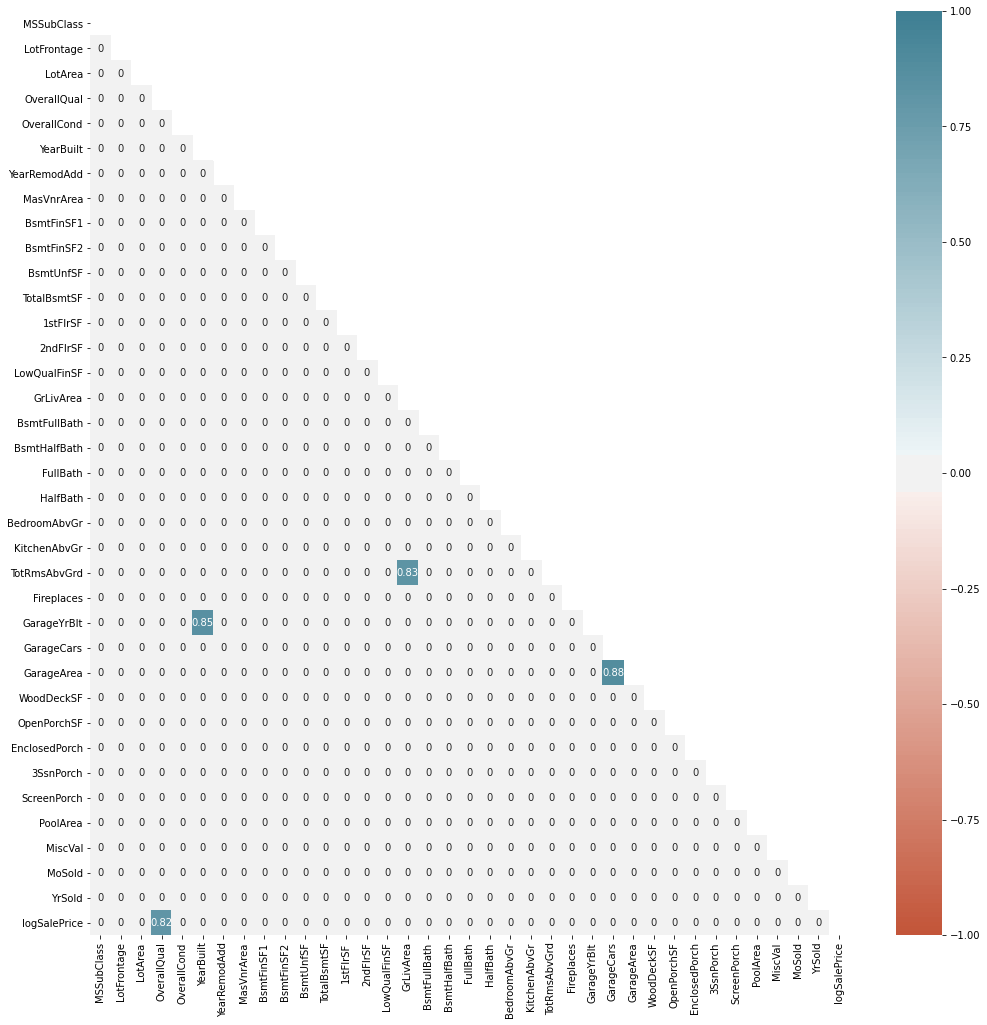

In [0]:
img_mat = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/corr_diag.png'
Image(filename=img_mat)

The plot above shows wich numerical data are correlated the most (**correlation value above 0.8 - the others are put to 0 in order for us to focus on the important information**). Three of them are relevant : 
- *YearBuilt* and *GarageYrBlt*
- *GrLiveArea* and *TotRmsAbvGrd* 
- *GarageArea* and *GareCars* 

We checked in the data set 1 (with the least amount of features) if it only kept one of the two. It actually did.

# II. Model Selection 

## II.1 Choosing between several baseline models

We tried several algorithms before focusing particularly on one of them. 
We tried: 
* Linear Models (Ridge, Eleastic, Lasso)
* Neural Networks
* XGBoost
* Random Forest 

**[Method]** : We tried **each of them** on **each data set** without tuning any parameter. Here are the results : 

In [0]:
linear = pd.DataFrame(data_lin, columns = columns, index = index)

linear.style.highlight_min(color='yellow',axis=None)

,Data_set_1 (47),Data_set_2 (75),Data_set_3 (138),Data_set_4 (all)
Linear Regression,0.124320,0.123277,0.121356,0.128013
Ridge,0.124180,0.122913,0.118678,0.118966
Lasso,0.186598,0.186598,0.186756,0.186756
Lasso Lars,0.399844,0.399844,0.399844,0.399844
Elastic Net,0.180085,0.181434,0.180179,0.178951
Support Vector Machine,0.216939,0.217100,0.217310,0.217361


The **Ridge regression** seems to give us the best results, with a best mean squared error of **0.1187** (obtained with the training set with 138 features). We also computed the standard deviation, which appeared to be small (0.008). It is not surprising as it is generally used for creating parsimonious models in presence of a ‘large’ number of features, which is our case. 

In [0]:
other = pd.DataFrame(data_other, columns = columns, index = index_2)

other.style.highlight_min(color='yellow',axis=1)

,Data_set_1 (47),Data_set_2 (75),Data_set_3 (138),Data_set_4 (all)
Random Forest,0.139720,0.139510,0.139930,0.139520
Neural Network,39.760680,27.822580,29.206590,36.032620
XGBoost,0.130416,0.129821,0.128398,0.127217


## II.2 Tuning the 4 selected models

We decided then to focus on : 
- (One of the six linear algorithms) : **Ridge**, on the **third data set (with 138 features)**
- **Random Forest** and **Neural Network**, on the **second data set (with 75 features)**
- **XGBoost**, on the **last data set (with all the features)** 


**We perfomed hyperparameter tuning on them.** Each time, we used a **grid search with cross-validation**.

---



---



> **Ridge**: 
  - The 2 main hyperparameters that we tuned are : 
    - the solver 
    - the regularization parameter alpha.

> **Random** Forest: 
  - The 3 main hyperparameters that we tuned are : 
      - n_estimators 
      - max_features
      - max_depth

> **Neural_Network**: 
  - We decided to build a simple neural network with 2 layers.
  >> The parameters that we tuned are :
    - batch_size : the size of the batches that are going to pass through the neural network
    - n_epoch : the number of time all training data are going to pass (backward and forward) through the network
    - optimizer : the optimization algorithm
    - weight_init : the distribution we use to initialize the weights
activation function
    - number of neurons in hidden layers. 
  - We tuned the parameters one after the other.

> **XGBoost**:
  - The overall parameters have been divided into 3 categories by XGBoost authors:
    - **General Parameters**: Guide the overall functioning
    - **Booster Parameters**: Guide the individual booster (tree/regression) at each step
    - **Learning Task Parameters**: Guide the optimization performed
  - This parameters tuning has been done with 4 steps: 
      - Define the optimal number of trees for a fixed learning rate
      - Tune tree-specific parameters for the LR and number of tree found
      - Tune regularization parameters      
      - Lower the learning rate 

Here are the results, once the parameters have been tuned. (The value of each parameter has not been displayed for more visibility, but can be found in the scratch version >> )


In [0]:
result = pd.DataFrame(data_3, columns = columns_2, index = index_3)

result.style.highlight_min(color='yellow',axis=None)

,RMSE
Ridge,0.116170
Random Forest,0.138300
Neural Network,0.259490
XGBoost,0.117260


> Global remarks : 

The performance of the models is better after tuning the hyperparameters.
However, the quest for performance comes with a cost : the computational cost of a Grid Search to test all combinations of the provided hyperparameters is high.

> For individual remarks on each algorithm, we encourage you to see our scratch version : 
  - Random Forest : 
  - Neural Network : 
  - XGBoost : 

We decided to focus on the Ridge model, as it was the one which gave the best results.

## II.3 Focusing on Ridge Algorithm

### > Remarks

- Tuning the regularization parameter alpha and the solver thanks to a Grid Search allowed us to conclude that the best alpha parameter is 8.123, and the best solver is 'Auto', as it leads to a root mean square error on a 5-fold cross-validation of **0.1162**, which is better than the one previously found with the default parameters.
- Having a high regularization parameter is a good thing as the higher the value of alpha is, the lower is the model complexity. Thus, we can hope that this model would not lead to overfitting.

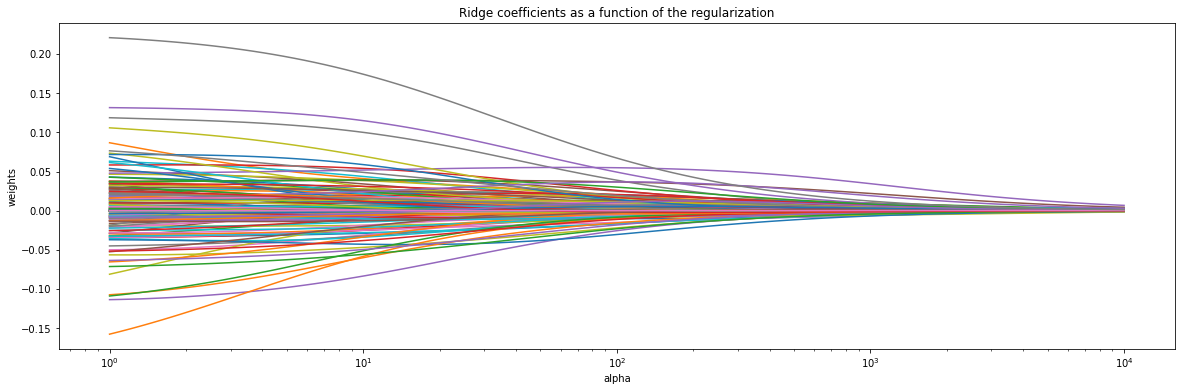

In [0]:
img = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/coeff_ridge.png'
Image(filename=img)

We were working on the third dataset, so the one with 138 features. Thus, we have to optimize 138 coefficients. To see how those coefficients behave with respect to the regularization parameter alpha, we plotted them just above. 

We can see than the more alpha is small, the more the coefficients are large and this can lead to overfitting. In our case, the best result is obtained with alpha = 8.15, which is a good thing as it is big enough to hope our model will not overfit. 

### > Going back to features selection

* We wanted to analyze the impact of the features selection on the model. 
* We thus applied once again the Recursive Feature Elimination with Cross Validation algorithm, setting the optimized Ridge Regressor as the model. This method gave us wich features to keep to obtain the lowest RMSE.

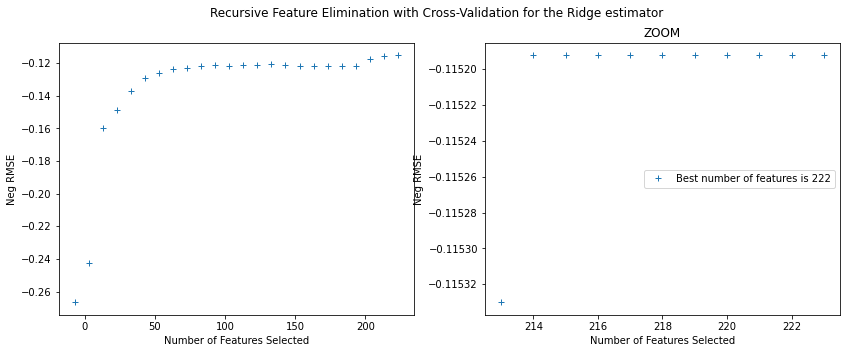

In [0]:
img = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/Fitted_Ridge.png'
Image(filename=img)

We found that we needed to keep **222 features** to have the best results. We obtained : **RMSE = 0.115** (with CV). It is a bit better compared to what we have with a non-fitted data set (we previously had 0.116), but the difference is not huge. 

Indeed the Ridge algorithm doesn't give much weight to the features it considers not important. That is the reason why having 138 or 222 features doesn't change the result much. 

To confirm this idea, we plotted on a histogram, the importance given to each feature.

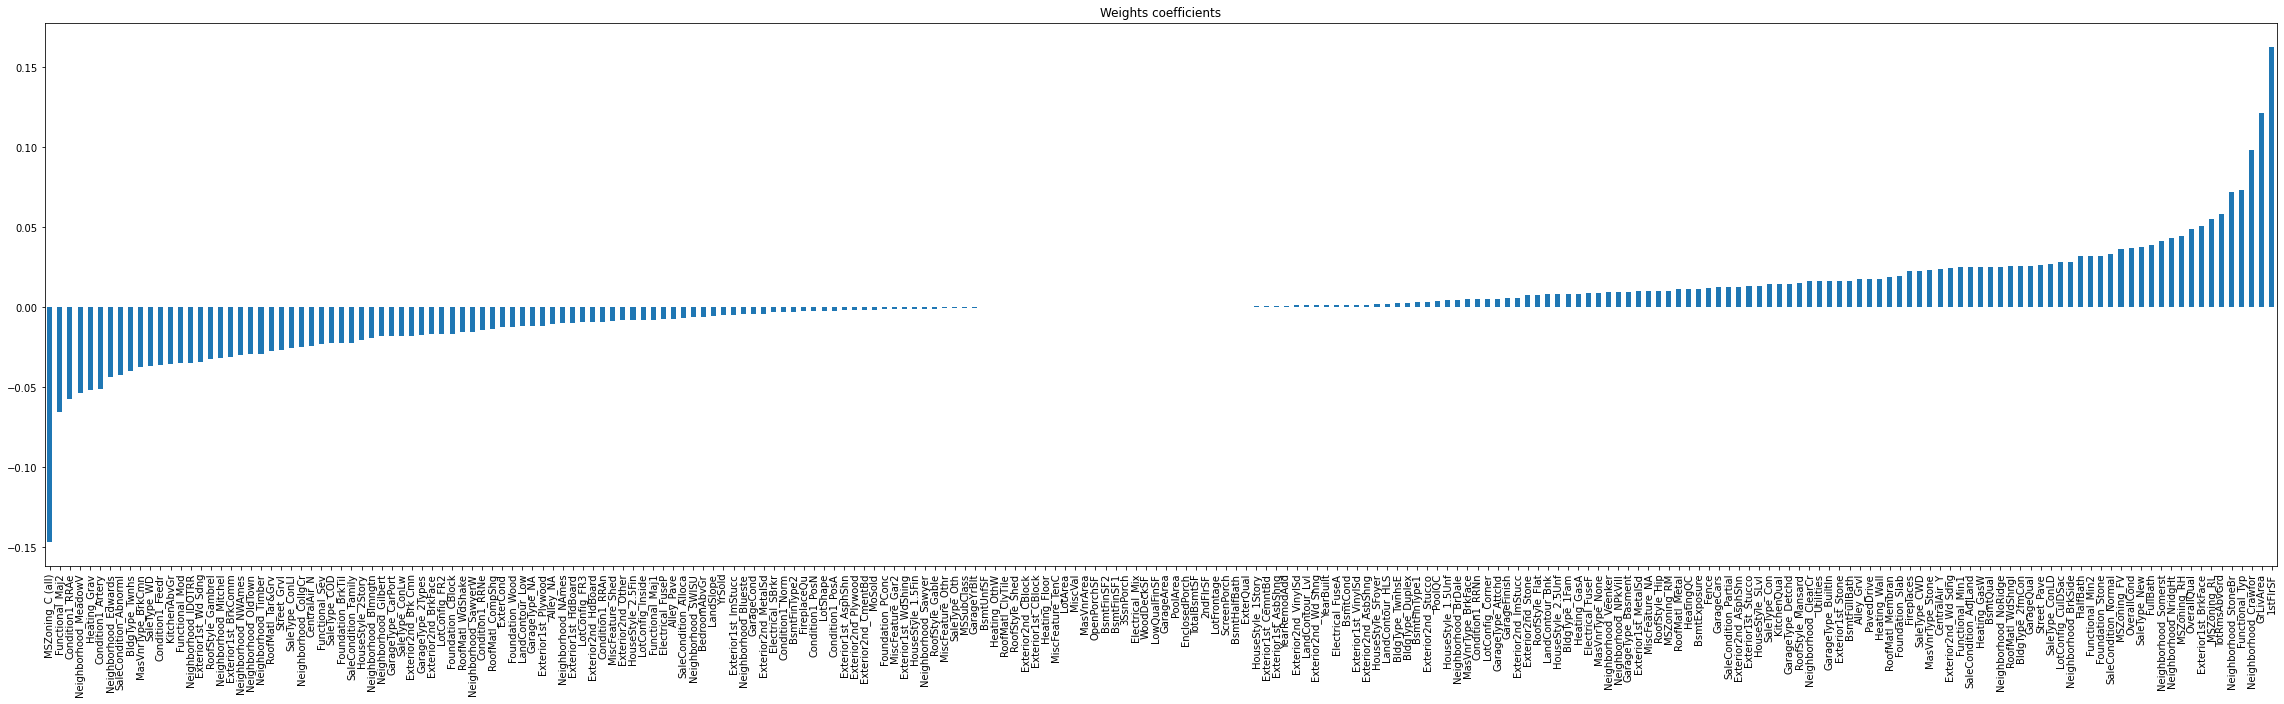

In [0]:
img = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/weigh_ridge.png'
Image(filename=img)

The plot showing the weights values of the final model allows to know what brings each feature to the final price. 

We can conclude thanks to this plot that the TOP 3 features influencing the price in a good way are: 
- the area of the 1st floor (*1stFlrSF*) 
- the above ground living area (*GrLivArea*)
- houses located in Crawford (*Neighborhood_Crawfor*)

The TOP 3 features that reduce the price of houses are: 
- Houses that are adjacent to East-West Railroad (*Condition1_RRAe*)
- Houses with major deductions 2 (*Functional_Maj2*)
- Houses located in a commercial zoning (*MSZoning_C*)

We can finally see the features that don't bring nothing to the price (those whose wieghts are near 0), such as the year the garage has been built (*GarageYrBlt*). 

# III. Performance Analysis

The following plot shows the prediction, as a function of the target points.

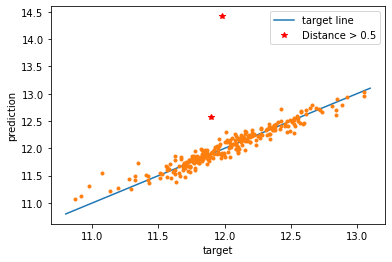

In [0]:
img = '/content/drive/My Drive/House Pricing Prediction Challenge/Emma/Final_test.png'
Image(filename=img)

We obtained **RMSE = 0.187** on the test set.


**Final Remarks on these results**:
- We can see that the models fits well a great part of the unseen data, as it matches the curve y=x.
- However, there are some aberrant points (the stars). 
- What about the worst prediction? We saw that it had very good values for the features that are the most important to our Ridge model to predict the price:

  - 1stFlrSF: with an area of 8.45, it is bigger than the maximum of the same feature of training set (7.97)
  - GrLivArea: here also, it is bigger than the maximum reached by the training set
  - TotRmsAbvGrd: it reaches almost the maximum value of the training set


- If we didn't have them, we figured that we would have an RMSE of 0.1038! 
- Assumption : Maybe our outliers removal steps made it harder for the model to match the atypical data. We tried it, and actually, the result was a bit better (regarding the fact that the one prediction that is aberrant is smaller - around 14.2).

Conclusion : 
To conclude, we can say that we developed a model accurately fits the available training data while also generalising to unseen data-points, as long as there is no aberrations.

---



---

